In [1]:
'''
This file reproduces a model for classifying figures to two classes: with cat (1) or without cat (0).

The model uses a logistic regression method to generate a classifier, and uses gradient descent method to locate global optima.
'''

'\nThis file reproduces a model for classifying figures to two classes: with cat (1) or without cat (0).\n\nThe model uses a logistic regression method to generate a classifier, and uses gradient descent method to locate global optima.\n'

In [2]:
# Import essential packages

import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [3]:
# Load data

train_dataset = h5py.File('datasets/train_catvnoncat.h5','r')
test_dataset = h5py.File('datasets/test_catvnoncat.h5','r')

train_set_x_orig = np.array(train_dataset['train_set_x'][:]) # train set features
train_set_y_orig_o = np.array(train_dataset['train_set_y'][:])
train_set_y_orig = train_set_y_orig_o.reshape(1,-1) # train set labels

test_set_x_orig = np.array(test_dataset['test_set_x'][:]) # train set features
test_set_y_orig_o = np.array(test_dataset['test_set_y'][:]) # train set labels
test_set_y_orig = test_set_y_orig_o.reshape(1,-1)

classes = np.array(test_dataset['list_classes'][:]) # the list of classes


y= [1], it is a cat picture.


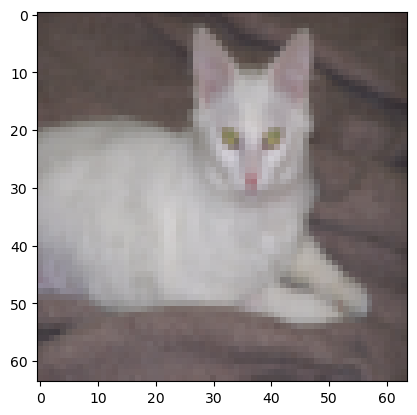

In [4]:
# Show a picture

index = 109

plt.imshow(train_set_x_orig[index])
print('y= ' + str(train_set_y_orig[:,index]) + ', it is a ' + classes[np.squeeze(train_set_y_orig[:,index])].decode('utf-8')+' picture.')

In [5]:
# Data Curation - Produce train and test data for modeling

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T 
# lay all pixels of RGB dots down (to a 1-dimension array) for each train sample
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
# lay all pixels of RGB dots down (to a 1-dimension array) for each test sample

train_set_x = train_set_x_flatten/255 # Normalize the RGB number of each pixel by maximum value 255
test_set_x = test_set_x_flatten/255
train_set_y = train_set_y_orig
test_set_y = test_set_y_orig

print('The shape of x for train set is {}, and for test set is {}'.format(train_set_x.shape,test_set_x.shape))
print('The shape of y for train set is {}, and for test set is {}'.format(train_set_y.shape,test_set_y.shape))



The shape of x for train set is (12288, 209), and for test set is (12288, 50)
The shape of y for train set is (1, 209), and for test set is (1, 50)


In [6]:
# Function building for the model
# Sigmoid function

def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [7]:
# Initialize w (vector) and b (float) with 0-value.

def initialize_with_zeros(dim):
    w = np.zeros((dim,1)) # a column vector of w matches number of features of X
    b = float(0)
    return w,b

In [8]:
# Computes the cost function and its gradient

def propagate(w,b,X,Y):
    m = X.shape[1] # number of samples, indicated by the number of columns of X
    z = np.dot(w.T,X) + b # u = w.T*X+b, use np.dot function to compute z for sigmoid function; produces a row vector with shape of (1,m)
    A = sigmoid(z)
    L = -(Y*np.log(A) + (1-Y)*np.log(1-A)) # compute the loss function for all samples
    cost = 1/m*np.sum(L) # compute the cost function by averaging J of all samples
    dz = A-Y # compute the gradient of z
    dw = 1/m*np.dot(X,dz.T) # compute the gradient of w
    db = 1/m*np.sum(dz) # compute the gradient of b

    cost = np.squeeze(np.array(cost))

    grads = {'dw':dw,
            'db':db}
    return grads,cost

In [9]:
# Optimize the factors w and b by minimizing cost function J

def optimize(w,b,X,Y,num_iterations=100,learning_rate=0.009,print_cost=False):
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)

    costs = []

    for i in range(num_iterations): # conduct "number of iterations" times of gradient descent process
        grads, cost = propagate(w,b,X,Y) # compute the gradient and cost function from the beginning of the round
        dw = grads['dw']
        db = grads['db']
        w -= learning_rate*dw # perform gradient descent
        b -= learning_rate*db
        if i%10 == 0:
            costs.append(cost) # add the result of cost function to the result base every 10 times of iterations
            if print_cost:
                print('Cost after {} times iteration: {}'.format(i,cost)) # show the cost value on the screen after certain number of iterations
    params = {'w':w,
            'b':b}
    grads = {'dw':dw,
            'db':db}
    costs = list(np.squeeze(costs))
    return params, grads, costs

In [10]:
# Use the trained model to predict the label
def predict(w,b,X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m)) # set predicted labels to be zeros for number of samples
    w = w.reshape(X.shape[0],1) # reshape w to make sure it aligns with number of features
    z = np.dot(w.T,X)+b
    A = sigmoid(z) # compute the prediction from logistic regression function
    for i in range(A.shape[1]):
        if A[0,i]>0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
    return Y_prediction


In [11]:
# Compile the model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    w, b = initialize_with_zeros(X_train.shape[0]) # create an array of w with 'number of features' 0-s, and assign b to be 0
    params, grads, costs = optimize(w,b,X_train,Y_train,num_iterations = num_iterations, learning_rate = learning_rate, print_cost=print_cost)
    w = params['w']
    b = params['b']
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    if print_cost:
        print('train accuracy: {} %'.format(100 - np.mean(np.abs(Y_prediction_train - Y_train))*100))
        print('test accuracy: {}%'.format(100 - np.mean(np.abs(Y_prediction_test - Y_test))*100))
    
    d = {'costs': costs,
        'Y_prediction_test': Y_prediction_test,
        'Y_prediction_train': Y_prediction_train,
        'w':w,
        'b':b,
        'learning_rate':learning_rate,
        'num_iterations':num_iterations}

    return d


In [12]:
# Test the model using train and test datasets:

logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after 0 times iteration: 0.6931471805599453
Cost after 10 times iteration: 0.7449403578103343
Cost after 20 times iteration: 0.719248930310633
Cost after 30 times iteration: 0.6973357819554409
Cost after 40 times iteration: 0.677814225655342
Cost after 50 times iteration: 0.6599250465088032
Cost after 60 times iteration: 0.643247578333392
Cost after 70 times iteration: 0.6275206683091039
Cost after 80 times iteration: 0.6125676331969916
Cost after 90 times iteration: 0.5982617123850421
Cost after 100 times iteration: 0.5845083636993086
Cost after 110 times iteration: 0.5712352015686087
Cost after 120 times iteration: 0.5583857594703387
Cost after 130 times iteration: 0.545915360378744
Cost after 140 times iteration: 0.5337882557626192
Cost after 150 times iteration: 0.5219755887224391
Cost after 160 times iteration: 0.5104539293174177
Cost after 170 times iteration: 0.4992042311980021
Cost after 180 times iteration: 0.4882111162133115
Cost after 190 times iteration: 0.477462430262

In [13]:
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')

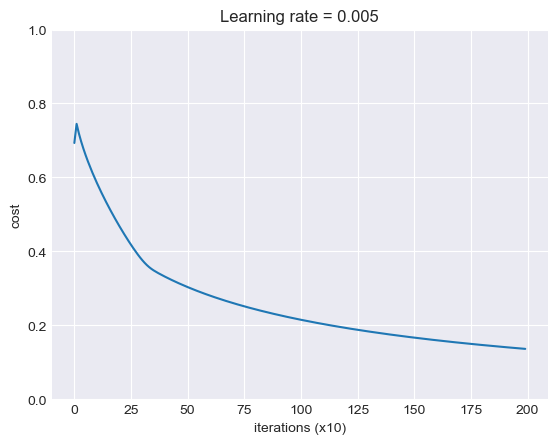

In [14]:
# Plot a learning curve:

costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (x10)')
plt.ylim([0,1])
plt.title('Learning rate = ' + str(logistic_regression_model['learning_rate']))
plt.show()

training a model with learning rate: 0.0001

Finished training!
--------

training a model with learning rate: 0.0005

Finished training!
--------

training a model with learning rate: 0.001

Finished training!
--------

training a model with learning rate: 0.005

Finished training!
--------

training a model with learning rate: 0.01

Finished training!
--------



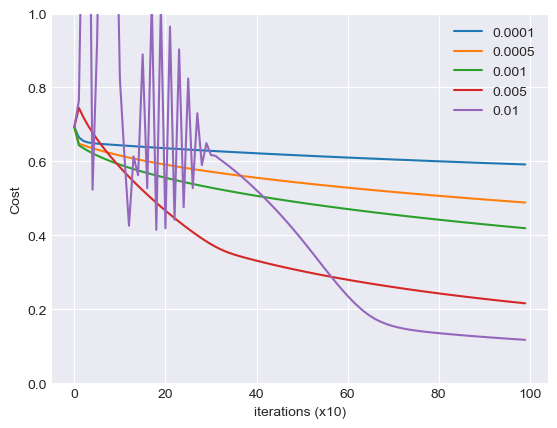

In [15]:
# Explore the relationship between learning rate and learning curve

learning_rates = [0.0001,0.0005,0.001,0.005,0.01]
models = {}

for learning_rate in learning_rates:
    print('training a model with learning rate: {}'.format(learning_rate))
    models[str(learning_rate)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1000, learning_rate=learning_rate, print_cost=False)
    print('\nFinished training!\n--------\n')

plt.figure()
for learning_rate in learning_rates:
    plt.plot(np.squeeze(models[str(learning_rate)]['costs']), label=str(models[str(learning_rate)]['learning_rate']))

plt.xlabel('iterations (x10)')
plt.ylabel('Cost')
plt.ylim([0,1])
legend = plt.legend(loc='upper right',shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

y = 0.0, the algorithm predicts a non-cat picture.


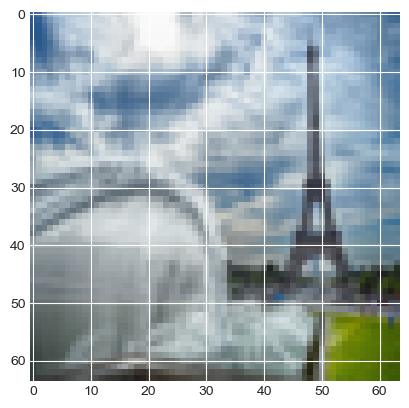

In [16]:
# predict your own image

my_image = 'datasets/Files/my_image.jpg'

image = np.array(Image.open(my_image).resize((64,64)))
plt.imshow(image)
image = image/255
image = image.reshape((1,-1)).T
my_predicted_image = predict(logistic_regression_model['w'],logistic_regression_model['b'],image)

print('y = ' + str(np.squeeze(my_predicted_image)) + ', the algorithm predicts a ' + \
     classes[int(np.squeeze(my_predicted_image))].decode('utf-8') + ' picture.')